### Lab 2 (Mandatory)
#### Ali Alghamdi

# Lab 2: Debug a Broken Vanilla GAN (find 12+ issues)

### Importing things

In [1]:
import torch, torchvision, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

### Choosing the device

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Get one batch
images, labels = next(iter(loader))

print(images.shape)  # torch.Size(batch_size, channels, height, width)


torch.Size([256, 1, 28, 28])


In [13]:
### DADGUM PEST SERVICE IS HERE 🐞🐞🐞🐞

# 1 - normalization bug :
# the GAN expects images to be normalized to [-1, 1]

# 2 - resizing bug :
# the cnn needs the images to be of one size, lets go 32

IMAGE_SIZE = 32 # 28 --> 32 good size

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # BUG 2 SQUISHED 🐞
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # BUG 1 SQUISHED 🐞
])

loader=DataLoader( # not exactly a bug, i just made it 5 lines instead of 1
#   torchvision.datasets.MNIST(root,    train   download    transform)
    torchvision.datasets.MNIST('./data',True,download=True,transform=transform),
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True)

z_dim=100

# 3 - generator learning rate :
# the generator learning rate is way too low

g_lr=0.0005 # 0.02 (VERY LOW) --> 0.0002

# 4 - discriminator learning rate :
# the discriminator learning rate is way too high

d_lr=0.0002 # 0.00002 (VERY HIGH) --> 0.0002


# ----------------
# Discriminator
# ----------------


class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),   # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 8x8 -> 4x4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),  # 4x4 -> 1x1
            # 5 - redundant signmoid
            # it needs to be gone cuz later we use BCE Loss which expects raw logits
            # but i will change the bce loss itself to make it like the one in the lab
            # i will change the BCE one to expect no logits
            # update : ill also remove the sigmoid cuz its the 'best practice'
            ### nn.Sigmoid()
        )

    def forward(self, x):
        # Flatten output to (batch_size, 1)
        return self.net(x).view(x.size(0), 1)

# ----------
# Generator
# ----------

class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(100, 128, kernel_size=4, stride=1, padding=0),  # latent z -> 4x4
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 4x4 -> 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 8x8 -> 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # not exaclty a bug,, but i had to add layers to accomodate 32x32 output

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 16x16 -> 32x32
            # 6 - missing tanh activation
            nn.Tanh()  # scale output to [-1,1] for GAN training
        )

    def forward(self, z):
        # 7 - reshaping
        # reshape z to match expected input of first ConvTranspose2d
        # the first layer expects 100 channels not 64
        z = z.view(z.size(0), 100, 1, 1)
        return self.net(z)

# ------
# Device
# ------
device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------
# Instantiate models
# ------------------
Dnet = D().to(device)
Gnet = G().to(device)

# -------------------
# Loss and optimizers
# -------------------

# 8 - changing this function instead of the sigmoid
crit = nn.BCEWithLogitsLoss()

opt_d = torch.optim.Adam(Dnet.parameters(), lr=d_lr, betas=(0.9, 0.999))
opt_g = torch.optim.Adam(Gnet.parameters(), lr=g_lr, betas=(0.9, 0.999))


In [23]:
for epoch in range(100):  # Add epoch loop
    for real, _ in tqdm(loader):
        real = real.to(device)               # Move real images to GPU (or device)
        b = real.size(0)                     # Get batch size

        # ----------------------------
        # Generate fake images
        # ----------------------------
        z = torch.randn(b, z_dim, device=device)       # Sample latent vectors
        fake = Gnet(z.view(b, z_dim, 1, 1))           # Generate fake images

        # ----------------------------
        # Discriminator loss
        # ----------------------------
        loss_d = crit(
            Dnet(real), torch.ones(b,1,device=device)  # BUG: labels are swapped (real should be 1) - FIXED
        ) + crit(
            Dnet(fake.detach()), torch.zeros(b,1,device=device)  # BUG: labels are swapped (fake should be 0) - FIXED. Detach fake to prevent backprop through G
        )

        opt_d.zero_grad()
        loss_d.backward()    # Backprop through discriminator
        opt_d.step()         # BUG: wrong optimizer! Should be opt_d - FIXED

        # ----------------------------
        # Generator loss
        # ----------------------------
        z = torch.randn(b, z_dim, device=device)       # Sample new latent vectors
        fake = Gnet(z.view(b, z_dim, 1, 1))           # Generate fake images
        loss_g = crit(
            Dnet(fake), torch.ones(b,1,device=device)  # BUG: non-saturating trick missing, wrong labels - FIXED (non-saturating trick uses real labels for fake images)
        )
        opt_g.zero_grad()
        loss_g.backward()     # BUG: missing optimizer step for generator - FIXED
        opt_g.step()

    print(f"Epoch {epoch+1}/500, Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}") # Print epoch loss

100%|██████████| 235/235 [00:14<00:00, 15.88it/s]


Epoch 1/500, Loss D: 0.0000, Loss G: 12.2511


100%|██████████| 235/235 [00:14<00:00, 16.13it/s]


Epoch 2/500, Loss D: 0.0000, Loss G: 11.6838


100%|██████████| 235/235 [00:14<00:00, 16.26it/s]


Epoch 3/500, Loss D: 0.0000, Loss G: 11.4222


100%|██████████| 235/235 [00:14<00:00, 16.05it/s]


Epoch 4/500, Loss D: 0.0001, Loss G: 10.5357


100%|██████████| 235/235 [00:14<00:00, 15.87it/s]


Epoch 5/500, Loss D: 0.0001, Loss G: 13.6589


100%|██████████| 235/235 [00:15<00:00, 15.36it/s]


Epoch 6/500, Loss D: 0.0000, Loss G: 12.2335


100%|██████████| 235/235 [00:15<00:00, 15.33it/s]


Epoch 7/500, Loss D: 0.0002, Loss G: 11.0951


100%|██████████| 235/235 [00:14<00:00, 16.17it/s]


Epoch 8/500, Loss D: 0.0220, Loss G: 5.2353


100%|██████████| 235/235 [00:14<00:00, 16.02it/s]


Epoch 9/500, Loss D: 0.0084, Loss G: 5.9129


100%|██████████| 235/235 [00:14<00:00, 16.10it/s]


Epoch 10/500, Loss D: 0.0276, Loss G: 5.8186


100%|██████████| 235/235 [00:14<00:00, 16.08it/s]


Epoch 11/500, Loss D: 0.0401, Loss G: 6.1740


100%|██████████| 235/235 [00:14<00:00, 16.15it/s]


Epoch 12/500, Loss D: 0.0097, Loss G: 6.5356


100%|██████████| 235/235 [00:15<00:00, 14.75it/s]


Epoch 13/500, Loss D: 0.0186, Loss G: 5.7206


100%|██████████| 235/235 [00:14<00:00, 15.91it/s]


Epoch 14/500, Loss D: 0.0271, Loss G: 5.6111


100%|██████████| 235/235 [00:14<00:00, 16.02it/s]


Epoch 15/500, Loss D: 0.1279, Loss G: 5.7684


100%|██████████| 235/235 [00:14<00:00, 15.93it/s]


Epoch 16/500, Loss D: 0.0520, Loss G: 5.7543


100%|██████████| 235/235 [00:14<00:00, 15.99it/s]


Epoch 17/500, Loss D: 0.0237, Loss G: 5.3878


100%|██████████| 235/235 [00:14<00:00, 15.99it/s]


Epoch 18/500, Loss D: 0.0308, Loss G: 6.5952


100%|██████████| 235/235 [00:14<00:00, 15.72it/s]


Epoch 19/500, Loss D: 0.4739, Loss G: 5.3146


100%|██████████| 235/235 [00:15<00:00, 15.35it/s]


Epoch 20/500, Loss D: 0.0282, Loss G: 5.9508


100%|██████████| 235/235 [00:14<00:00, 16.06it/s]


Epoch 21/500, Loss D: 0.0208, Loss G: 6.9170


100%|██████████| 235/235 [00:15<00:00, 15.66it/s]


Epoch 22/500, Loss D: 0.0531, Loss G: 4.6406


100%|██████████| 235/235 [00:15<00:00, 15.51it/s]


Epoch 23/500, Loss D: 0.0561, Loss G: 3.6861


100%|██████████| 235/235 [00:15<00:00, 15.07it/s]


Epoch 24/500, Loss D: 0.0371, Loss G: 5.0231


100%|██████████| 235/235 [00:16<00:00, 14.34it/s]


Epoch 25/500, Loss D: 0.0477, Loss G: 6.0101


100%|██████████| 235/235 [00:15<00:00, 14.89it/s]


Epoch 26/500, Loss D: 0.0517, Loss G: 6.3682


100%|██████████| 235/235 [00:15<00:00, 15.14it/s]


Epoch 27/500, Loss D: 0.0316, Loss G: 6.5129


100%|██████████| 235/235 [00:15<00:00, 15.34it/s]


Epoch 28/500, Loss D: 0.0915, Loss G: 5.3367


100%|██████████| 235/235 [00:15<00:00, 15.56it/s]


Epoch 29/500, Loss D: 0.0232, Loss G: 5.2033


100%|██████████| 235/235 [00:15<00:00, 14.73it/s]


Epoch 30/500, Loss D: 0.0600, Loss G: 6.4344


100%|██████████| 235/235 [00:15<00:00, 15.38it/s]


Epoch 31/500, Loss D: 0.0375, Loss G: 5.3137


100%|██████████| 235/235 [00:15<00:00, 15.12it/s]


Epoch 32/500, Loss D: 0.0178, Loss G: 5.5728


100%|██████████| 235/235 [00:15<00:00, 15.20it/s]


Epoch 33/500, Loss D: 0.0082, Loss G: 5.7553


100%|██████████| 235/235 [00:15<00:00, 15.51it/s]


Epoch 34/500, Loss D: 0.0177, Loss G: 5.9699


100%|██████████| 235/235 [00:16<00:00, 14.45it/s]


Epoch 35/500, Loss D: 1.9721, Loss G: 2.0614


100%|██████████| 235/235 [00:15<00:00, 15.51it/s]


Epoch 36/500, Loss D: 0.0426, Loss G: 4.9480


100%|██████████| 235/235 [00:15<00:00, 15.18it/s]


Epoch 37/500, Loss D: 0.0232, Loss G: 7.3509


100%|██████████| 235/235 [00:15<00:00, 15.22it/s]


Epoch 38/500, Loss D: 0.0549, Loss G: 5.5992


100%|██████████| 235/235 [00:15<00:00, 15.25it/s]


Epoch 39/500, Loss D: 0.0164, Loss G: 6.7302


100%|██████████| 235/235 [00:16<00:00, 14.29it/s]


Epoch 40/500, Loss D: 0.0292, Loss G: 5.8611


100%|██████████| 235/235 [00:15<00:00, 15.35it/s]


Epoch 41/500, Loss D: 0.0110, Loss G: 5.5695


100%|██████████| 235/235 [00:15<00:00, 15.37it/s]


Epoch 42/500, Loss D: 0.0341, Loss G: 4.5019


100%|██████████| 235/235 [00:15<00:00, 15.24it/s]


Epoch 43/500, Loss D: 0.0209, Loss G: 5.7745


100%|██████████| 235/235 [00:15<00:00, 15.45it/s]


Epoch 44/500, Loss D: 0.0290, Loss G: 5.7917


100%|██████████| 235/235 [00:16<00:00, 14.32it/s]


Epoch 45/500, Loss D: 0.0201, Loss G: 5.7122


100%|██████████| 235/235 [00:15<00:00, 15.36it/s]


Epoch 46/500, Loss D: 0.0259, Loss G: 4.6539


100%|██████████| 235/235 [00:15<00:00, 15.13it/s]


Epoch 47/500, Loss D: 0.0085, Loss G: 8.1200


100%|██████████| 235/235 [00:15<00:00, 15.45it/s]


Epoch 48/500, Loss D: 0.0194, Loss G: 6.1509


100%|██████████| 235/235 [00:15<00:00, 15.30it/s]


Epoch 49/500, Loss D: 0.0049, Loss G: 3.9875


100%|██████████| 235/235 [00:16<00:00, 14.66it/s]

Epoch 50/500, Loss D: 0.0239, Loss G: 5.0900


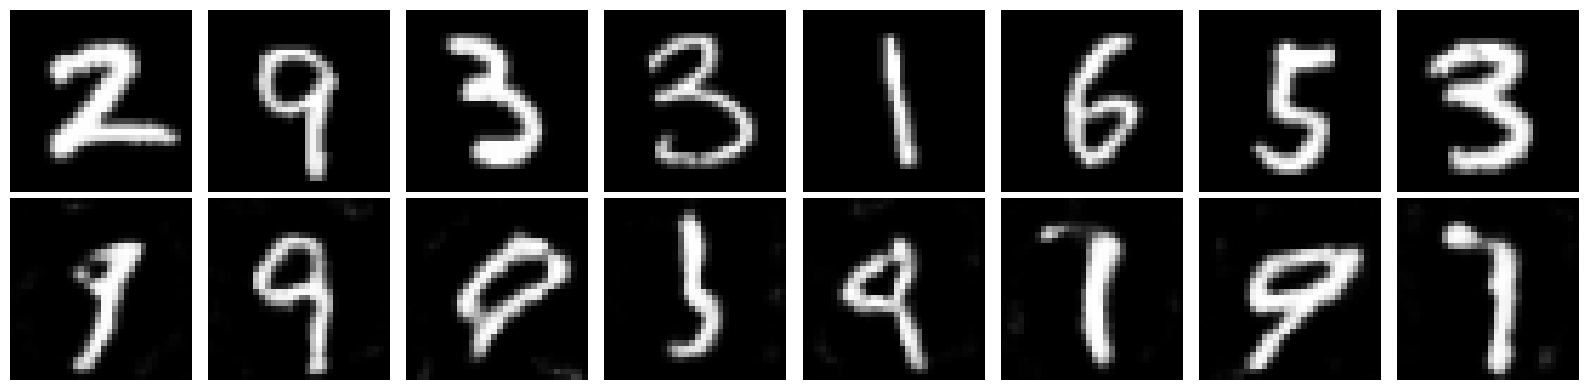

In [24]:
### CHATGPT GEENRATED CODE ###

import matplotlib.pyplot as plt
import torchvision

# Function to plot a batch of images
def show_images(real_images, fake_images, n=8):
    """
    real_images, fake_images: tensors (batch_size, 1, H, W)
    n: number of images per row
    """
    # Undo normalization (if using Normalize((0.5,), (0.5,)))
    real_images = real_images * 0.5 + 0.5
    fake_images = fake_images * 0.5 + 0.5

    # Convert to CPU and numpy for plotting
    real_images = real_images.detach().cpu()
    fake_images = fake_images.detach().cpu()

    # Plot real images
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(real_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel("Real", fontsize=12)

    # Plot fake images
    for i in range(n):
        plt.subplot(2, n, n+i+1)
        plt.imshow(fake_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel("Fake", fontsize=12)

    plt.tight_layout()
    plt.show()


# -----------------------------
# Example usage after one batch
# -----------------------------
real, _ = next(iter(loader))
real = real.to(device)
b = real.size(0)

z = torch.randn(b, z_dim, device=device)
fake = Gnet(z.view(b, z_dim, 1, 1))

show_images(real, fake, n=8)  # shows first 8 real and fake images


### The losses tell us that the discriminator is winning too easily
GENERATOR DIFF